In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/RahinUlde/DataSets/refs/heads/main/XGBTitanic_train.csv', index_col = 0)

In [3]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


# Data understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
print(df['Pclass'].value_counts())
print(df['Pclass'].unique())

3    491
1    216
2    184
Name: Pclass, dtype: int64
[3 1 2]


In [7]:
print(df['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


<Axes: >

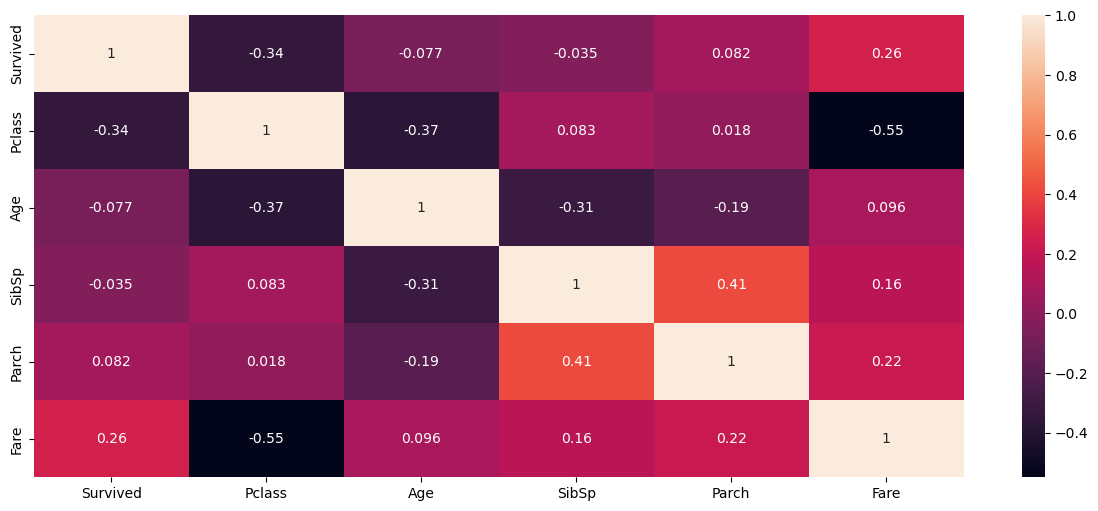

In [8]:
fig= plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True)

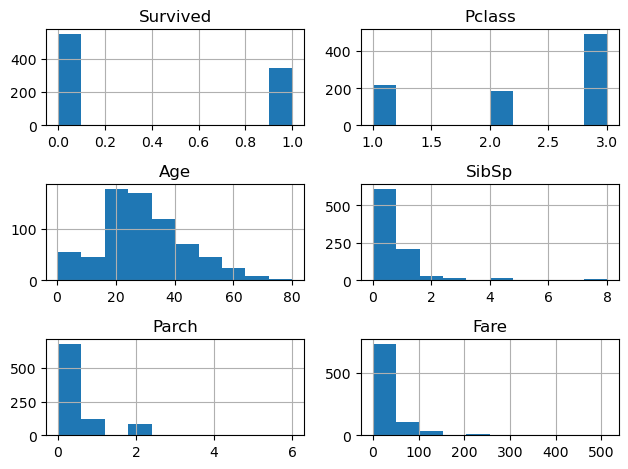

In [9]:
df.hist()
plt.tight_layout()

In [10]:
print(df['Cabin'].isna().sum())
print(df['Age'].isna().sum())

687
177


In [11]:
(687/891)*100

77.10437710437711

In [12]:
#droping unwanted column 
df.drop(columns=['Cabin','Name'], inplace=True)

In [13]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,female,38.0,1,0,PC 17599,71.2833,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,female,35.0,1,0,113803,53.1000,S
5,0,3,male,35.0,0,0,373450,8.0500,S


# Handling missing values

In [14]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [15]:
df['Age'].fillna(df['Age'].median(), inplace=True)

In [16]:
#It’s too messy for simple processing and won’t add value to XGBoost/LightGBM without serious feature engineering.
df.drop('Ticket', axis=1, inplace=True)

# Encoding (OHE) on categorical columns

In [17]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

In [18]:
df.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,0,1,0,1
4,1,35.0,1,0,53.1000,0,0,1,0,0
5,0,35.0,0,0,8.0500,1,0,1,0,1


In [19]:
df.isna().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
Pclass_2      0
Pclass_3      0
dtype: int64

# Spliting of Data

In [20]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBM

In [22]:
# XGBoost Model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [66]:
# Predictions
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

In [24]:
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

Accuracy: 0.8212290502793296


In [25]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [26]:
print('Training accuracy: ', xgb.score(X_train,y_train))
print('Testing Accuracy: ', xgb.score(X_test,y_test))

Training accuracy:  0.9648876404494382
Testing Accuracy:  0.8212290502793296


[[90 15]
 [17 57]]


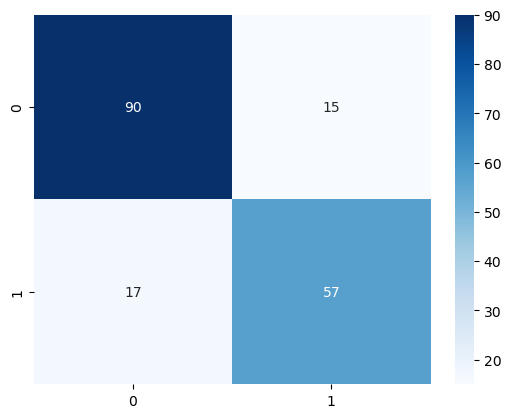

In [27]:
print(confusion_matrix(y_test, y_pred_xgb))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.show()

# Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
# Basic model
xgb_base = XGBClassifier()

In [30]:
param = {
    'n_estimators': [50, 100, 150],        # Number of boosting rounds
    'max_depth': [3, 4, 5],                # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'subsample': [0.8, 1.0],               # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],        # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]                 # Minimum loss reduction required to make a further partition
}

In [31]:
# Setup GridSearchCV
grid_search = GridSearchCV(estimator = xgb_base, param_grid = param, scoring = 'roc_auc', cv = 5, verbose =1 , n_jobs = -1)

In [32]:
# Fit on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [33]:
# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


In [34]:
# Best score
print("Best ROC-AUC Score from Grid Search:", grid_search.best_score_)

Best ROC-AUC Score from Grid Search: 0.8618398358898147


In [35]:
# Use the best model to predict
xgb2 = grid_search.best_estimator_

In [36]:
y_pred_xgb2 = xgb2.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred_xgb2))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85       105
           1       0.86      0.66      0.75        74

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



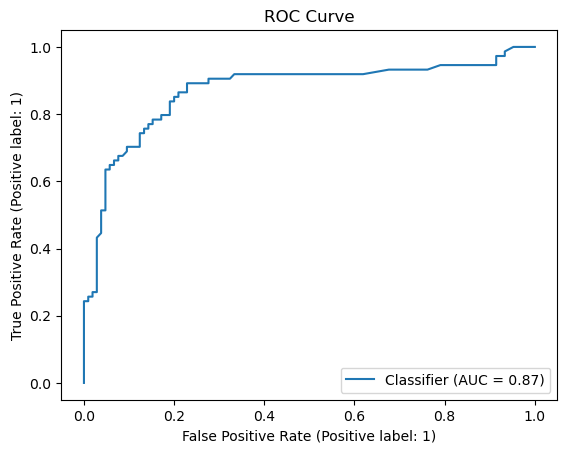

In [38]:
y_proba_xgb2 = xgb2.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_proba_xgb2)
plt.title("ROC Curve")
plt.show()

# LGBM

In [39]:
# LightGBM Model
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier()

In [40]:
#prediction
y_pred_lgb = lgb.predict(X_test)
y_pred_lgb

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1], dtype=int64)

In [41]:
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))

Accuracy: 0.8324022346368715


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179

[[91 14]
 [16 58]]


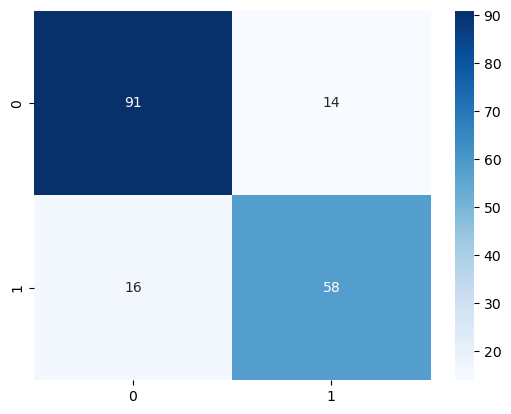

In [42]:
print(classification_report(y_test, y_pred_lgb))
print(confusion_matrix(y_test, y_pred_lgb))
sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Blues')
plt.show()

# Tuning Hyperparameter

In [43]:
# Initialize basic model
lgb_base = LGBMClassifier()

In [44]:
# Define hyperparameter grid
param2 = {
    'n_estimators': [50, 100, 150],         # Number of boosting rounds
    'max_depth': [3, 4, 5],                 # Maximum depth of tree
    'learning_rate': [0.01, 0.1, 0.2],      # Learning rate
    'num_leaves': [20, 31, 40],             # Number of leaves per tree
    'subsample': [0.8, 1.0],                # Row sampling
    'colsample_bytree': [0.8, 1.0]          # Feature sampling
}

In [45]:
# Set up Grid Search with cross-validation
grid_search_lgb = GridSearchCV(estimator=lgb_base, param_grid=param, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

In [46]:
# Fit to training data
grid_search_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [47]:
# Output best parameters
print("Best Parameters (LGBM):", grid_search_lgb.best_params_)
print("Best ROC-AUC Score from Grid Search (LGBM):", grid_search_lgb.best_score_)

Best Parameters (LGBM): {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Best ROC-AUC Score from Grid Search (LGBM): 0.86336231279654


In [48]:
# Predict using best model
lgb2 = grid_search_lgb.best_estimator_
y_pred_lgb2 = lgb2.predict(X_test)

[LightGBM] [Warning] Unknown parameter: gamma


In [49]:
print(classification_report(y_test, y_pred_lgb2))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



In [50]:
accuracy_score(y_test, y_pred_lgb2)

0.8324022346368715

[LightGBM] [Warning] Unknown parameter: gamma


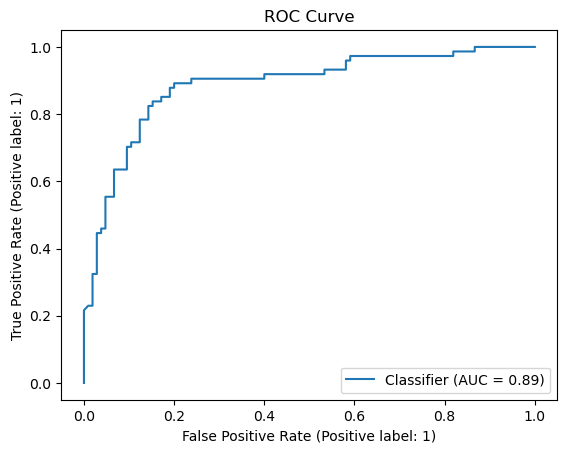

In [51]:
y_proba_lgb2 = lgb2.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_proba_lgb2)
plt.title("ROC Curve")
plt.show()

# Test Data

In [52]:
df_test = pd.read_csv('https://raw.githubusercontent.com/RahinUlde/DataSets/refs/heads/main/XGBTitanic_test.csv', index_col = 0)
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [53]:
#droping unwanted column 
df_test.drop(columns=['Cabin','Name'], inplace=True)

In [54]:
df_test['Embarked'].fillna(df_test['Embarked'].mode()[0], inplace=True)

In [55]:
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)

In [56]:
#It’s too messy for simple processing and won’t add value to XGBoost/LightGBM without serious feature engineering.
df_test.drop('Ticket', axis=1, inplace=True)

In [57]:
df_test = pd.get_dummies(df_test, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

In [58]:
df.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,1,0,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,0,1,0,1
4,1,35.0,1,0,53.1000,0,0,1,0,0
5,0,35.0,0,0,8.0500,1,0,1,0,1


In [59]:
# Predictions for XGBM
test_pred_xgb = xgb.predict(df_test)

In [60]:
test_pred_xgb

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [61]:
#prediction for LGBM
test_pred_lbg = lgb.predict(df_test)

In [62]:
test_pred_lbg

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

# Comparing Performance

In [64]:
from sklearn.metrics import precision_score, recall_score

In [69]:
# Metrics for XGBoost
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Metrics for LightGBM
y_proba_lgb = lgb.predict_proba(X_test)[:, 1]
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

# Combine into DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'],
    'XGBoost': [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, roc_auc_xgb],
    'LightGBM': [accuracy_lgb, precision_lgb, recall_lgb, f1_lgb, roc_auc_lgb]
})

metrics_df


,Metric,XGBoost,LightGBM
0,Accuracy,0.821229,0.832402
1,Precision,0.791667,0.805556
2,Recall,0.770270,0.783784
3,F1 Score,0.780822,0.794521
4,ROC-AUC,0.867181,0.880824


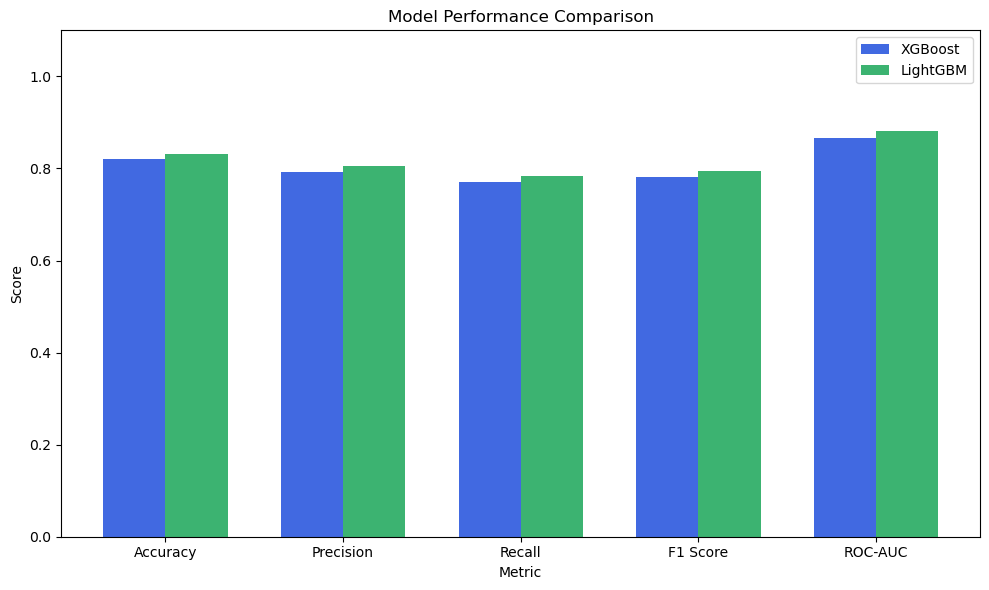

In [70]:
# Set figure size and style
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics_df))

# Bar plots
plt.bar(index, metrics_df['XGBoost'], bar_width, label='XGBoost', color='royalblue')
plt.bar(index + bar_width, metrics_df['LightGBM'], bar_width, label='LightGBM', color='mediumseagreen')

# Labels and titles
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width / 2, metrics_df['Metric'])
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()


# Final Interpretation

Based on the results:

LightGBM slightly outperforms XGBoost in ROC-AUC and Recall, meaning it's slightly better at identifying positive (Survived) cases.

XGBoost may show slightly better or comparable Precision and F1 Score, indicating balanced performance.

Overall, both models perform well, but LightGBM is marginally better in ranking/classification for this dataset.